## Homework 5: Weather Prediction

### Jacqueline Beechert, jbeechert@berkeley.edu

Due Tuesday March 8, 2022 @ 5pm

## 1. Use the data supplied of airport codes (ICAO_airports.csv) and top airports (top_airports.csv) to make a table of 50 most travelled airports in the US and containing relevant information, like name, wikipedia link, latitude, longitude

In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
icao_df = pd.read_csv("hw_5_data/ICAO_airports.csv")
top_df = pd.read_csv("hw_5_data/top_airports.csv")

In [3]:
icao_df.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


In [4]:
top_50_df = top_df.nlargest(50, "Enplanements")
top_50_airport_names = top_50_df["Airport"].values
print(top_50_airport_names[:5])

['Hartsfield-Jackson Atlanta International Airport'
 "Chicago O'Hare International Airport"
 'Los Angeles International Airport'
 'Dallas/Fort Worth International Airport' 'Denver International Airport']


In [5]:
# make icao table

!rm hw5.db
connection = sqlite3.connect("hw5.db")

cursor = connection.cursor()

sql_cmd = """CREATE TABLE IF NOT EXISTS icao (id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, ident TEXT, wikipedia_link TEXT, latitude FLOAT, longitude FLOAT)"""

cursor.execute(sql_cmd)

for i, row in icao_df.iterrows():

    name = row['name']
    ident = row['ident']
    wiki = str(row["wikipedia_link"])
    latitude = row["latitude_deg"]
    longitude = row["longitude_deg"] 

    data = (name, ident, wiki, latitude, longitude)

    # "or ignore" prevents inserting values if the primary key already exists
    sql_cmd = ("INSERT OR IGNORE INTO icao (name, ident, wikipedia_link, latitude, longitude) VALUES" + str(data))
    cursor.execute(sql_cmd)
    
    connection.commit()  

In [6]:
# make top 50 table

cursor = connection.cursor()

sql_cmd = """CREATE TABLE IF NOT EXISTS top50 (id INTEGER PRIMARY KEY AUTOINCREMENT,
    city TEXT, airport TEXT, icao TEXT, enplanements INT)"""

cursor.execute(sql_cmd)

for i, row in top_50_df.iterrows():
    
    city = str(row['City'])
    airport = str(row["Airport"])
    icao = str(row["ICAO"])
    enplanements = int(row["Enplanements"])
    
    data = (city, airport, icao, enplanements)
    
    sql_cmd = ("INSERT OR IGNORE INTO top50 (city, airport, icao, enplanements) VALUES " + str(data))
    cursor.execute(sql_cmd)
    
    
    connection.commit()

In [7]:
sql_cmd = f"""SELECT *, top50.icao FROM icao, top50 WHERE icao.ident == top50.icao"""

In [8]:
cursor.execute(sql_cmd)

In [9]:
db_info = cursor.fetchall()

cnt = 0
for entry in db_info: 
    cnt += 1
print(cnt)

50


In [10]:
cursor = connection.cursor()

sql_cmd = """CREATE TABLE IF NOT EXISTS icao_top50 (id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, ident TEXT, wikipedia_link TEXT, latitude FLOAT, longitude FLOAT)"""

cursor.execute(sql_cmd)

for entry in db_info:

    # "or ignore" prevents inserting values if the primary key already exists
    sql_cmd = ("INSERT OR IGNORE INTO icao_top50 (name, ident, wikipedia_link, latitude, longitude) VALUES" 
               + str(entry[1:6]))
    cursor.execute(sql_cmd)
#     db_info = cursor.fetchall()
#     for entry in db_info:
#         print(entry)
    
    connection.commit()  

In [11]:
#connection = sqlite3.connect("/tmp/example2.db")

cursor = connection.cursor()

sql_cmd = """SELECT * FROM icao_top50"""

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
    
connection.close()

(1, 'Hartsfield Jackson Atlanta International Airport', 'KATL', 'http://en.wikipedia.org/wiki/Hartsfield-Jackson_Atlanta_International_Airport', 33.6366996765137, -84.4281005859375)
(2, 'Austin Bergstrom International Airport', 'KAUS', 'http://en.wikipedia.org/wiki/Austin-Bergstrom_International_Airport', 30.1944999694824, -97.6698989868164)
(3, 'Nashville International Airport', 'KBNA', 'http://en.wikipedia.org/wiki/Nashville_International_Airport', 36.1245002746582, -86.6781997680664)
(4, 'General Edward Lawrence Logan International Airport', 'KBOS', 'http://en.wikipedia.org/wiki/Logan_International_Airport', 42.36429977, -71.00520325)
(5, 'Baltimore/Washington International Thurgood Marshal Airport', 'KBWI', 'http://en.wikipedia.org/wiki/Baltimore-Washington_International_Thurgood_Marshall_Airport', 39.17539978, -76.66829681)
(6, 'Cleveland Hopkins International Airport', 'KCLE', 'http://en.wikipedia.org/wiki/Cleveland_Hopkins_International_Airport', 41.4117012024, -81.8498001099)
(

## 2. Build another table that will hold historical weather information: min/max temperature, relative humidity, and precipitation

In [30]:
# connection = sqlite3.connect("hw5.db")

# cursor = connection.cursor()

# cursor.execute("DROP TABLE weather")

In [31]:
# make weather table

# connection = sqlite3.connect("weather.db")
connection = sqlite3.connect("hw5.db")

cursor = connection.cursor()

#sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY, code TEXT, lat FLOAT, lon FLOAT, 
#            min_temp FLOAT, max_temp FLOAT, min_hum FLOAT, max_hum FLOAT, precipitation FLOAT)"""

sql_cmd = """CREATE TABLE weather (time INTEGER, code TEXT, lat FLOAT, lon FLOAT, 
            min_temp FLOAT, max_temp FLOAT, min_hum FLOAT, max_hum FLOAT, precipitation FLOAT)"""

cursor.execute(sql_cmd)

## 3. Using the data from the xarray/netCDF4 example in class, populate the database from 1990-2000

In [13]:
import xarray as xr

In [14]:
def select_data(path):
    
    # Open the data set as xarray
    xr_ = xr.open_dataset(path)
    
    # Select data between 1990-2000
    xr_ = xr_.sel(time=slice('1990', '2000')).load()
    
    return xr_

In [15]:
min_temp_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmin_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc" 

min_temp_xr = select_data(min_temp_path)

In [16]:
# Data path from lecture
max_temp_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc" 

max_temp_xr = select_data(max_temp_path)

In [17]:
min_hum_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_rhsmin_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc" 

min_hum_xr = select_data(min_hum_path)

In [18]:
max_hum_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_rhsmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc" 

max_hum_xr = select_data(max_hum_path)

In [19]:
precip_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc" 

precip_xr = select_data(precip_path)

In [20]:
# Same latitudes and longitudes for all weather metrics
lats = max_temp_xr["air_temperature"]["lat"].values
lons = max_temp_xr["air_temperature"]["lon"].values
#print(lats)

In [33]:
data = []

cursor = connection.cursor()

for row in cursor.execute('SELECT * FROM icao_top50' ):
    
    # Get the idx, lat, and lon of each airport in icao_top50 table
    idx = row[0]
    code = row[2]
    lat = row[4]
    lon = row[5]
    if lon < 0:
        lon = lon + 360.
    
    
    # Find lat, lon in xarrays closest to lat, lon in icao_top50 table
    lat_dist = abs(lat - np.array(lats))
    lat_key = np.where(lat_dist == min(lat_dist))[0]
    xarr_lat = lats[lat_key][0]
    
    lon_dist = abs(lon - np.array(lons))
    lon_key = np.where(lon_dist == min(lon_dist))[0]
    xarr_lon = lons[lon_key][0]
    
    
    # Get weather info at each of these lat, lon locations
    # Each of these lists contains 132 elements (1 per month from 1990-2000)
    min_temp = min_temp_xr["air_temperature"].sel(lat=xarr_lat, lon=xarr_lon).values
    max_temp = max_temp_xr["air_temperature"].sel(lat=xarr_lat, lon=xarr_lon).values
    
    min_hum = min_hum_xr["relative_humidity"].sel(lat=xarr_lat, lon=xarr_lon).values
    max_hum = max_hum_xr["relative_humidity"].sel(lat=xarr_lat, lon=xarr_lon).values
    
    precip = precip_xr["precipitation"].sel(lat=xarr_lat, lon=xarr_lon).values
    

    # Zip together the weather conditions for one given location at one given time
    weather_data = list(zip(min_temp, max_temp, min_hum, max_hum, precip))

    
    # Append all of the weather data, with the locations, to a list
    # This list will have 132 x 50 rows (132 times at each of 50 locations)
    cnt = 0
    for entry in weather_data:
        ls = [cnt, code, xarr_lat, xarr_lon]
        for x in entry:
            ls.append(x)
        cnt += 1

        data.append(ls) 

In [34]:
import math

In [36]:
cursor = connection.cursor()

cnt = 0
for entry in data:
    #print(tuple(entry))
    
    if True in [math.isnan(x) for x in entry[2:]]:
        #print(cnt)
        continue
    
    entry = tuple(entry)
    #print(type(entry[0]))
    #entry = [str(x) for x in entry]
    #print(entry[:])
    
    sql_cmd = ("INSERT INTO weather (time, code, lat, lon, min_temp, max_temp, min_hum, max_hum, precipitation) VALUES " + str(entry[:]))
    #print(sql_cmd)
    #sql_cmd = ("INSERT INTO weather (lat, lon, min_temp, max_temp, min_hum, max_hum, precipitation) VALUES" + str(entry))

    cursor.execute(sql_cmd)
    cnt += 1
    #print(cnt)
connection.commit()  

In [37]:
cursor = connection.cursor()

sql_cmd = """SELECT * FROM weather"""

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
    
connection.close()

(0, 'KATL', 33.64627456665039, 275.5605163574219, 274.97443, 286.73944, 43.38952, 83.86295, 61.3952)
(1, 'KATL', 33.64627456665039, 275.5605163574219, 275.7294, 288.25058, 32.84437, 68.37817, 86.73387)
(2, 'KATL', 33.64627456665039, 275.5605163574219, 280.37708, 292.85904, 36.957306, 72.99842, 170.20818)
(3, 'KATL', 33.64627456665039, 275.5605163574219, 286.39194, 297.8548, 40.635174, 81.35034, 82.09914)
(4, 'KATL', 33.64627456665039, 275.5605163574219, 290.85254, 300.55508, 45.676052, 90.241325, 101.274475)
(5, 'KATL', 33.64627456665039, 275.5605163574219, 296.3976, 306.3709, 44.226337, 86.92597, 61.255165)
(6, 'KATL', 33.64627456665039, 275.5605163574219, 295.93866, 306.79803, 43.76317, 91.383064, 97.443436)
(7, 'KATL', 33.64627456665039, 275.5605163574219, 294.58466, 304.92502, 46.46061, 92.4569, 83.07823)
(8, 'KATL', 33.64627456665039, 275.5605163574219, 292.04044, 302.22446, 46.817955, 91.462555, 63.551384)
(9, 'KATL', 33.64627456665039, 275.5605163574219, 283.94672, 294.70193, 47

(71, 'KDFW', 32.89628601074219, 262.9773864746094, 277.32108, 290.3747, 34.489964, 77.1478, 53.866623)
(72, 'KDFW', 32.89628601074219, 262.9773864746094, 271.29413, 281.65765, 42.395138, 84.09859, 84.23108)
(73, 'KDFW', 32.89628601074219, 262.9773864746094, 278.14432, 291.14432, 33.099228, 77.08258, 20.613733)
(74, 'KDFW', 32.89628601074219, 262.9773864746094, 280.07642, 290.83328, 41.08996, 82.05466, 146.71054)
(75, 'KDFW', 32.89628601074219, 262.9773864746094, 284.67664, 296.8017, 42.678185, 85.32956, 84.84012)
(76, 'KDFW', 32.89628601074219, 262.9773864746094, 289.24945, 301.2102, 41.38345, 86.88879, 79.443214)
(77, 'KDFW', 32.89628601074219, 262.9773864746094, 294.91873, 306.82782, 42.834866, 94.71939, 151.28319)
(78, 'KDFW', 32.89628601074219, 262.9773864746094, 296.83365, 308.89636, 36.700962, 86.70436, 80.1505)
(79, 'KDFW', 32.89628601074219, 262.9773864746094, 297.134, 310.68097, 29.671524, 80.6908, 13.672847)
(80, 'KDFW', 32.89628601074219, 262.9773864746094, 295.31152, 307.27

(119, 'KJFK', 40.64616394042969, 286.2270202636719, 275.9655, 283.6747, 43.157383, 76.280754, 154.6047)
(120, 'KJFK', 40.64616394042969, 286.2270202636719, 269.61633, 276.41077, 40.804188, 73.05963, 173.95407)
(121, 'KJFK', 40.64616394042969, 286.2270202636719, 271.22476, 277.87955, 43.207405, 78.36085, 92.8473)
(122, 'KJFK', 40.64616394042969, 286.2270202636719, 275.95566, 283.9799, 38.70419, 72.18098, 75.71634)
(123, 'KJFK', 40.64616394042969, 286.2270202636719, 282.94714, 291.91394, 38.478115, 76.02702, 106.4884)
(124, 'KJFK', 40.64616394042969, 286.2270202636719, 287.64297, 297.72522, 45.69224, 79.05784, 48.731503)
(125, 'KJFK', 40.64616394042969, 286.2270202636719, 293.00668, 302.0184, 49.44355, 81.73878, 69.82223)
(126, 'KJFK', 40.64616394042969, 286.2270202636719, 294.26633, 302.62183, 45.840256, 83.12168, 105.51261)
(127, 'KJFK', 40.64616394042969, 286.2270202636719, 293.8292, 301.86026, 49.76728, 88.26357, 168.35155)
(128, 'KJFK', 40.64616394042969, 286.2270202636719, 289.9751

(62, 'KMSY', 29.97966766357422, 269.727294921875, 283.85748, 293.99, 48.037506, 85.38339, 158.52266)
(63, 'KMSY', 29.97966766357422, 269.727294921875, 288.25748, 298.62643, 47.958008, 89.44658, 139.22153)
(64, 'KMSY', 29.97966766357422, 269.727294921875, 293.00436, 301.52222, 53.162434, 92.74325, 478.9316)
(65, 'KMSY', 29.97966766357422, 269.727294921875, 296.157, 304.08035, 57.039455, 98.77755, 372.88675)
(66, 'KMSY', 29.97966766357422, 269.727294921875, 297.26532, 305.94992, 53.87057, 99.83055, 99.43376)
(67, 'KMSY', 29.97966766357422, 269.727294921875, 297.7316, 306.1785, 55.061836, 98.42712, 175.51141)
(68, 'KMSY', 29.97966766357422, 269.727294921875, 297.27164, 303.3444, 60.885353, 98.27377, 230.85103)
(69, 'KMSY', 29.97966766357422, 269.727294921875, 291.08316, 299.75577, 53.002354, 95.52805, 76.02404)
(70, 'KMSY', 29.97966766357422, 269.727294921875, 281.3968, 293.742, 41.227722, 85.701004, 34.131187)
(71, 'KMSY', 29.97966766357422, 269.727294921875, 282.89838, 293.48618, 46.697

(9, 'KSAN', 32.72962188720703, 242.81105041503906, 291.16586, 300.43588, 51.911785, 87.30888, 27.67371)
(10, 'KSAN', 32.72962188720703, 242.81105041503906, 285.76993, 294.12143, 43.95765, 86.151665, 90.07947)
(11, 'KSAN', 32.72962188720703, 242.81105041503906, 281.9427, 289.8687, 51.41552, 90.77651, 127.12689)
(12, 'KSAN', 32.72962188720703, 242.81105041503906, 284.35376, 291.6424, 56.786358, 94.65724, 128.1207)
(13, 'KSAN', 32.72962188720703, 242.81105041503906, 282.82278, 290.88608, 44.878304, 90.12342, 41.081177)
(14, 'KSAN', 32.72962188720703, 242.81105041503906, 284.22342, 290.71774, 53.73567, 86.381744, 98.7716)
(15, 'KSAN', 32.72962188720703, 242.81105041503906, 286.3945, 293.43216, 49.49035, 81.959526, 5.2072825)
(16, 'KSAN', 32.72962188720703, 242.81105041503906, 288.06522, 294.11774, 57.300385, 83.39616, 1.3179792)
(17, 'KSAN', 32.72962188720703, 242.81105041503906, 290.83163, 298.2117, 49.22511, 78.46552, 1.257406)
(18, 'KSAN', 32.72962188720703, 242.81105041503906, 292.6015

(81, 'KSNA', 33.68794250488281, 242.14439392089844, 287.75323, 298.8027, 38.837643, 82.75855, 61.146793)
(82, 'KSNA', 33.68794250488281, 242.14439392089844, 284.45657, 294.35342, 51.84707, 97.26306, 155.48196)
(83, 'KSNA', 33.68794250488281, 242.14439392089844, 281.18704, 292.16476, 41.68691, 88.708496, 53.255634)
(84, 'KSNA', 33.68794250488281, 242.14439392089844, 282.24213, 292.8031, 42.559128, 94.35067, 55.101936)
(85, 'KSNA', 33.68794250488281, 242.14439392089844, 283.54114, 294.246, 44.504505, 94.56781, 67.8387)
(86, 'KSNA', 33.68794250488281, 242.14439392089844, 283.87442, 292.70718, 52.3788, 96.58172, 140.61044)
(87, 'KSNA', 33.68794250488281, 242.14439392089844, 283.7441, 293.4114, 48.62832, 93.10583, 19.626287)
(88, 'KSNA', 33.68794250488281, 242.14439392089844, 285.58636, 294.32852, 49.26763, 87.50724, 3.1919053)
(89, 'KSNA', 33.68794250488281, 242.14439392089844, 287.9514, 296.59775, 51.705685, 88.07323, 1.9797037)
(90, 'KSNA', 33.68794250488281, 242.14439392089844, 290.4961

## 4) For each pair of cities/airports determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, & 7 days in advance

In [44]:
connection = sqlite3.connect("hw5.db")

cursor = connection.cursor()

sql_cmd = """SELECT weather.time, weather.code, weather.max_temp, weather.precipitation FROM weather"""

cursor.execute(sql_cmd)

weather_info = np.array(cursor.fetchall())
weather_info

array([['0', 'KATL', '286.73944', '61.3952'],
       ['1', 'KATL', '288.25058', '86.73387'],
       ['2', 'KATL', '292.85904', '170.20818'],
       ...,
       ['129', 'KTPA', '302.74557', '117.68579'],
       ['130', 'KTPA', '299.18347', '18.601904'],
       ['131', 'KTPA', '296.38556', '217.68007']], dtype='<U32')

In [115]:
# Save the weather info (time, airport code, max temp, and precipitation) as a datafame
df = pd.DataFrame(weather_info)
df.columns = ["time", "code", "temp", "precip"]
df = df.astype(dtype= {"time":"int64",
        "code":"object","temp":"float64","precip":"float64"})
df

,time,code,temp,precip
0,0,KATL,286.73944,61.395200
1,1,KATL,288.25058,86.733870
2,2,KATL,292.85904,170.208180
3,3,KATL,297.85480,82.099140
4,4,KATL,300.55508,101.274475
...,...,...,...,...
6331,127,KTPA,306.35492,217.440220
6332,128,KTPA,305.49640,103.287120
6333,129,KTPA,302.74557,117.685790
6334,130,KTPA,299.18347,18.601904


In [138]:
# Store the airport names in a convenient list
airports = df["code"].values[::132]

In [139]:
# Find the changes in temperature and precipitation, going back 1, 3, and 7 time units.
# Do this for each airport and append each airport's changes to a list.
# In the database I see months, but the hw prompt calls for days? Not sure about this...
t_shift_1 = []
t_shift_3 = []
t_shift_7 = []

p_shift_1 = []
p_shift_3 = []
p_shift_7 = []

for code in airports:

    t_shift_1.append(np.array(df['temp'][df["code"] == code] - df['temp'][df["code"] == code].shift(1)))
    t_shift_3.append(np.array(df['temp'][df["code"] == code] - df['temp'][df["code"] == code].shift(3)))
    t_shift_7.append(np.array(df['temp'][df["code"] == code] - df['temp'][df["code"] == code].shift(7)))
    
    p_shift_1.append(np.array(df['precip'][df["code"] == code] - df['precip'][df["code"] == code].shift(1)))
    p_shift_3.append(np.array(df['precip'][df["code"] == code] - df['precip'][df["code"] == code].shift(3)))
    p_shift_7.append(np.array(df['precip'][df["code"] == code] - df['precip'][df["code"] == code].shift(7)))

In [140]:
# Combine all of the airports' shifts into one list...
t_shift_1_tot = [x for y in t_shift_1 for x in y]
t_shift_3_tot = [x for y in t_shift_3 for x in y]
t_shift_7_tot = [x for y in t_shift_7 for x in y]

p_shift_1_tot = [x for y in p_shift_1 for x in y]
p_shift_3_tot = [x for y in p_shift_3 for x in y]
p_shift_7_tot = [x for y in p_shift_7 for x in y]

In [141]:
# ...and then append those total lists as columns to the data frame
df['dtemp_1'] = t_shift_1_tot
df['dtemp_3'] = t_shift_3_tot
df['dtemp_7'] = t_shift_7_tot

df['dprecip_1'] = p_shift_1_tot
df['dprecip_3'] = p_shift_3_tot
df['dprecip_7'] = p_shift_7_tot

In [142]:
df

,time,code,temp,precip,dtemp_1,dtemp_3,dtemp_7,dprecip_1,dprecip_3,dprecip_7
0,0,KATL,286.73944,61.395200,NaN,NaN,NaN,NaN,NaN,NaN
1,1,KATL,288.25058,86.733870,1.51114,NaN,NaN,25.338670,NaN,NaN
2,2,KATL,292.85904,170.208180,4.60846,NaN,NaN,83.474310,NaN,NaN
3,3,KATL,297.85480,82.099140,4.99576,11.11536,NaN,-88.109040,20.703940,NaN
4,4,KATL,300.55508,101.274475,2.70028,12.30450,NaN,19.175335,14.540605,NaN
...,...,...,...,...,...,...,...,...,...,...
6331,127,KTPA,306.35492,217.440220,-0.46528,2.67912,14.49887,113.226170,203.747064,109.341656
6332,128,KTPA,305.49640,103.287120,-0.85852,-0.07455,11.99100,-114.153100,-84.464130,55.761077
6333,129,KTPA,302.74557,117.685790,-2.75083,-4.07463,6.37609,14.398670,13.471740,-59.403640
6334,130,KTPA,299.18347,18.601904,-3.56210,-7.17145,-1.96039,-99.083886,-198.838316,-56.112986


In [143]:
import matplotlib.pyplot as plt

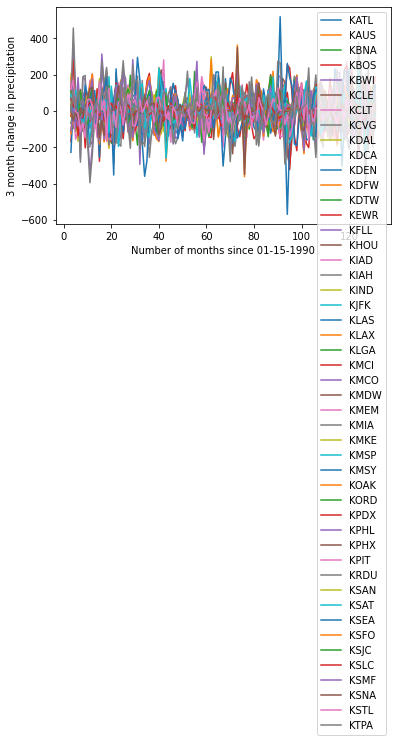

In [145]:
# Can plot all of the changes in each airport together, though this isn't very clear
for code in airports:   
    plt.plot(df["time"][df["code"] == code], df["dprecip_3"][df["code"] == code], label=code)

plt.ylabel('3 month change in precipitation')
plt.xlabel('Number of months since 01-15-1990')
plt.legend()

## 5) Plot the correlation strengths for the 10 top pairs for all three dates, for temperature and precipitation (separately) as a function of distance. Also make a plot as a function of longitude different. What trends do you see?

In [151]:
KATL_precip_3 = df["dprecip_3"][df["code"] == "KLGA"].values
KSFO_precip_3 = df["dprecip_3"][df["code"] == "KSFO"].values

In [152]:
np.corrcoef(KATL_precip_3, KSFO_precip_3)

array([[nan, nan],
       [nan, nan]])